# COMP90051 Workshop 4
## Regularization

***

In this worksheet, we'll explore regularization in the context of linear regression. Our key objectives are:

* to implement basis expansion and extend the linear regression model to include polynomial basis functions
* to understand the bias-variance trade-off and the role of regularization in controlling overfitting
* to implement ridge regression and LASSO regression

We'll reuse the Boston housing dataset from Workshop 3.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
plt.rcParams['figure.dpi'] = 108

### 1. The Boston Housing dataset

Throughout this worksheet, we'll use the _Boston Housing dataset_ as an example. 
It contains data about towns in the Boston area, which can be used to predict median house values. 
There are 506 observations in total, each of which is described by 13 features, such as _per capita crime rate_, _percentage of population with a lower socio-economic status_, etc. 
You can read more about the features [here](http://lib.stat.cmu.edu/datasets/boston).

Let's begin by loading the data (from scikit-learn) and converting to a Pandas dataframe.

In [2]:
from sklearn.datasets import load_boston
boston = load_boston()
ds = pd.DataFrame(boston.data, columns=boston.feature_names)
y = pd.Series(boston.target, name='MEDV')
ds.head()

d:\Applications\Miniconda3\envs\sml\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


To keep things simple, we'll work with a single feature called `LSTAT` for now. 
It corresponds to the percentage of the population in the town classified as 'lower status' by the US Census service in 1978. 
Note that the response variable (the median house value in the town) is denoted `MEDV`.
Plotting the  `MEDV` vs. `LSTAT` we see that a linear model appears plausible:

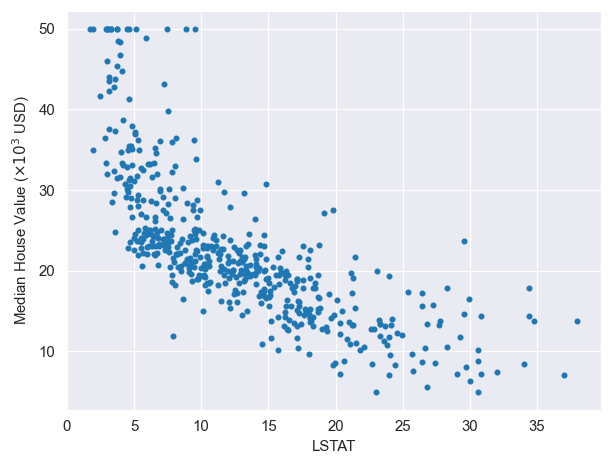

In [3]:
features = ['LSTAT']

#ds['LSTAT'] = ds['LSTAT'].apply(lambda x: x/100.)
for f in features:
    plt.figure()
    plt.scatter(ds[f], y, marker='.')
    plt.xlabel(f)
    plt.ylabel(r'Median House Value ($\times 10^3$ USD)')

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(ds, y, test_size=0.2, random_state=90051)
print("Training set has {} instances. Test set has {} instances.".format(X_train.shape[0], X_test.shape[0]))
# select subset of the features
X_train_s = X_train[features].values
X_test_s = X_test[features].values

Training set has 404 instances. Test set has 102 instances.


### 2. Recap: Linear regression

Recall that the linear regression model can be expressed as $\hat{y} = \mathbf{X}\mathbf{w}$, where $\mathbf{X}$ is the design matrix and $\mathbf{w}$ is the weight vector.
The optimal weights $\mathbf{w}^* = \left[\mathbf{X}^\top \mathbf{X}\right]^{-1} \mathbf{X}^\top \mathbf{y}$.

In [5]:
# Prepend a column of 1's to the design matrices (since we absorbed the bias term in the weights vector)
X_train_b = np.column_stack((np.ones_like(X_train_s), X_train_s))
X_test_b = np.column_stack((np.ones_like(X_test_s), X_test_s))
print('Design matrix shape:', X_train_s.shape)

w = np.linalg.solve((X_train_b.T @ X_train_b), (X_train_b.T @ y_train)) # fill in matmul @ np.dot
print('Weights:', w)

# @ matmul np.dot()

Design matrix shape: (404, 1)
Weights: [34.51530004 -0.95801769]


Let's check our implementation by plotting the predictions on the test data.

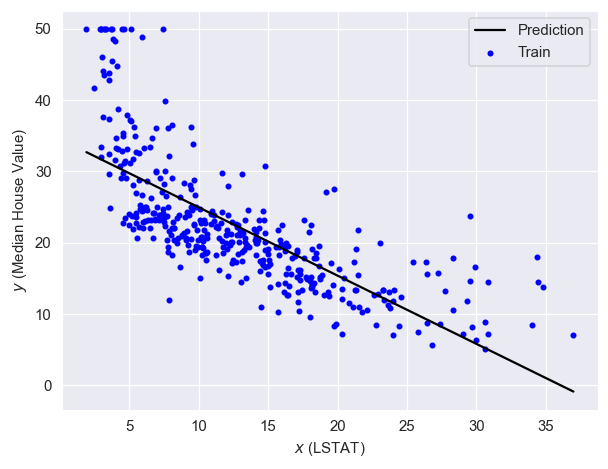

In [6]:
def predict(X, w):
    """Return the predicted response for a given design matrix and weights vector
    """
    return np.dot(X, w)

X_grid = np.linspace(X_train_s.min(), X_train_s.max(), num=1001)
x = np.column_stack((np.ones_like(X_grid), X_grid))
y = predict(x, w)
plt.plot(X_grid, y, 'k-', label='Prediction')
plt.scatter(X_train_s, y_train, color='b', marker='.', label='Train')
# plt.scatter(X_test_s, y_test, color='r', marker='.', label='Test')
plt.legend()
plt.ylabel("$y$ (Median House Value)")
plt.xlabel("$x$ (LSTAT)")
plt.show()

We'll compute the mean error term over the training and test sets to assess model performance.

In [7]:
def mean_squared_error(y_true, y_pred):
    return np.mean((y_pred - y_true)**2) 

y_pred_train = predict(X_train_b, w)
y_pred_test = predict(X_test_b, w)
print('Train MSE:', mean_squared_error(y_pred_train, y_train))
print('Test MSE:', mean_squared_error(y_pred_test, y_test))

Train MSE: 38.632216441608094
Test MSE: 38.00420488101304


Or we could use the `sklearn` library to do the same thing.

In [8]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(X_train_s, y_train)
y_pred_train = lr.predict(X_train_s)
y_pred_test = lr.predict(X_test_s)
print('Train MSE:', mean_squared_error(y_pred_train, y_train))
print('Test MSE:', mean_squared_error(y_pred_test, y_test))

Train MSE: 38.6322164416081
Test MSE: 38.00420488101308


But it is obvious that the linear model is not a good fit for the data since the relationship between `LSTAT` and `MEDV` is not linear. What if we don't want to change our model? What could we do to capture the non-linear relationship using a 'linear' model?

### 3. Basis expansion

Linear regression is simple and easy to interpret, however it cannot capture nonlinear relationships between the response and features. 
To deal with this problem, we can extend linear regression by mapping the features into another space where the relationship is (ideally) linear. 
This is known as _basis expansion_.
Specifically, we map the original feature vector $\mathbf{x} \in \mathbb{R}^m$ to a new feature vector $\varphi(\mathbf{x}) \in \mathbb{R}^k$. 
We then perform linear regression as before, replacing the original feature vectors with the new feature vectors: $y = w_0 + \sum_{i = 1}^{m} w_i \cdot \varphi_i(\mathbf{x})$. 
Note that this function is nonlinear in $\mathbf{x}$, but linear in $\mathbf{w}$. 

All of the previous results for simple linear regression carry over as you would expect by making the replacement $\mathbf{x} \to \varphi(\mathbf{x})$. 
For instance, the normal equation becomes: 

$$
\mathbf{w}^\star = \left[\mathbf{\Phi}^\top \mathbf{\Phi}\right]^{-1} \mathbf{\Phi}^\top \mathbf{y}
$$

where $\mathbf{\Phi} = \begin{pmatrix} \varphi(\mathbf{x}_1)^\top \\ \vdots \\ \varphi(\mathbf{x}_n)^\top \end{pmatrix}$ denotes the transformed design matrix.


There are many possible choices for the mapping $\varphi(\mathbf{x})$, but we'll focus on using polynomial basis functions in the single-feature case, e.g. $\varphi(x) = [1, x, x^2, \ldots, x^{k - 1}]^\top$ (note the first element corresponds to a bias term). 

We can compute the transformed design matrix using a built-in class from scikit-learn called `PolynomialFeatures`.
We'll start by considering polynomial features of degree 2.

In [9]:
from sklearn.preprocessing import PolynomialFeatures
degree = 2
poly = PolynomialFeatures(degree=degree)
Phi_train = poly.fit_transform(X_train_s)
Phi_test = poly.fit_transform(X_test_s)
print("Original design matrix (first 5 rows):\n", X_train_s[0:5], "\n")
print("Transformed design matrix (first 5 rows):\n", Phi_train[0:5])

Original design matrix (first 5 rows):
 [[12.8 ]
 [13.09]
 [27.38]
 [17.44]
 [ 1.92]] 

Transformed design matrix (first 5 rows):
 [[  1.      12.8    163.84  ]
 [  1.      13.09   171.3481]
 [  1.      27.38   749.6644]
 [  1.      17.44   304.1536]
 [  1.       1.92     3.6864]]


Now let's perform linear regression on the transformed training data and plot the resulting model. 

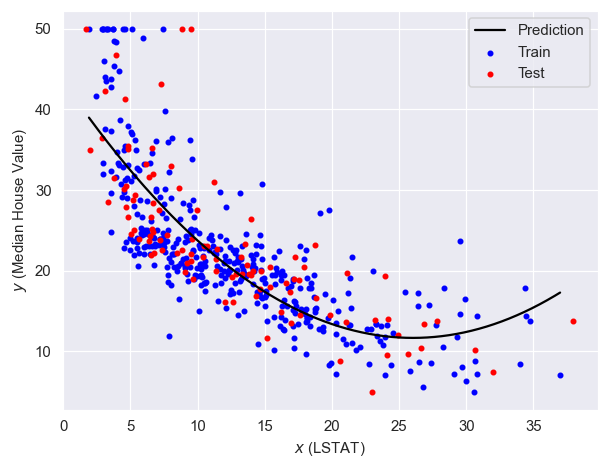

In [10]:
lr_poly = LinearRegression(fit_intercept=False).fit(Phi_train, y_train)

X_grid = np.linspace(X_train_s.min(), X_train_s.max(), num=1001)
Phi_grid = poly.fit_transform(X_grid[:,np.newaxis])
y = lr_poly.predict(Phi_grid)
plt.plot(X_grid, y, 'k-', label='Prediction')
plt.scatter(X_train_s, y_train, color='b', marker='.', label='Train')
plt.scatter(X_test_s, y_test, color='r', marker='.', label='Test')
plt.legend()
plt.ylabel("$y$ (Median House Value)")
plt.xlabel("$x$ (LSTAT)")
plt.show()

Seems like a better fit than the linear model! Let's take a look at the error terms on the train/test set:

In [11]:
y_pred_train_poly = lr_poly.predict(Phi_train)
y_pred_test_poly = lr_poly.predict(Phi_test)
print('Train MSE for polynomial features of degree {}: {:.3f}'.format(degree, mean_squared_error(y_pred_train_poly, y_train)))
print('Test MSE for polynomial features of degree {}: {:.3f}'.format(degree, mean_squared_error(y_pred_test_poly, y_test)))

print('Train MSE using linear features only: {:.3f}'.format(mean_squared_error(lr.predict(X_train_s), y_train)))
print('Test MSE using linear features only: {:.3f}'.format(mean_squared_error(lr.predict(X_test_s), y_test)))

Train MSE for polynomial features of degree 2: 29.535
Test MSE for polynomial features of degree 2: 33.760
Train MSE using linear features only: 38.632
Test MSE using linear features only: 38.004


Strange, a large reduction on the train MSE but not so much on the test MSE. 
Lets scan across a range of powers. 
What do you expect to happen as we increase the maximum polynomial order on the training set? 
Take a minute to discuss with your fellow students before executing the next cell.

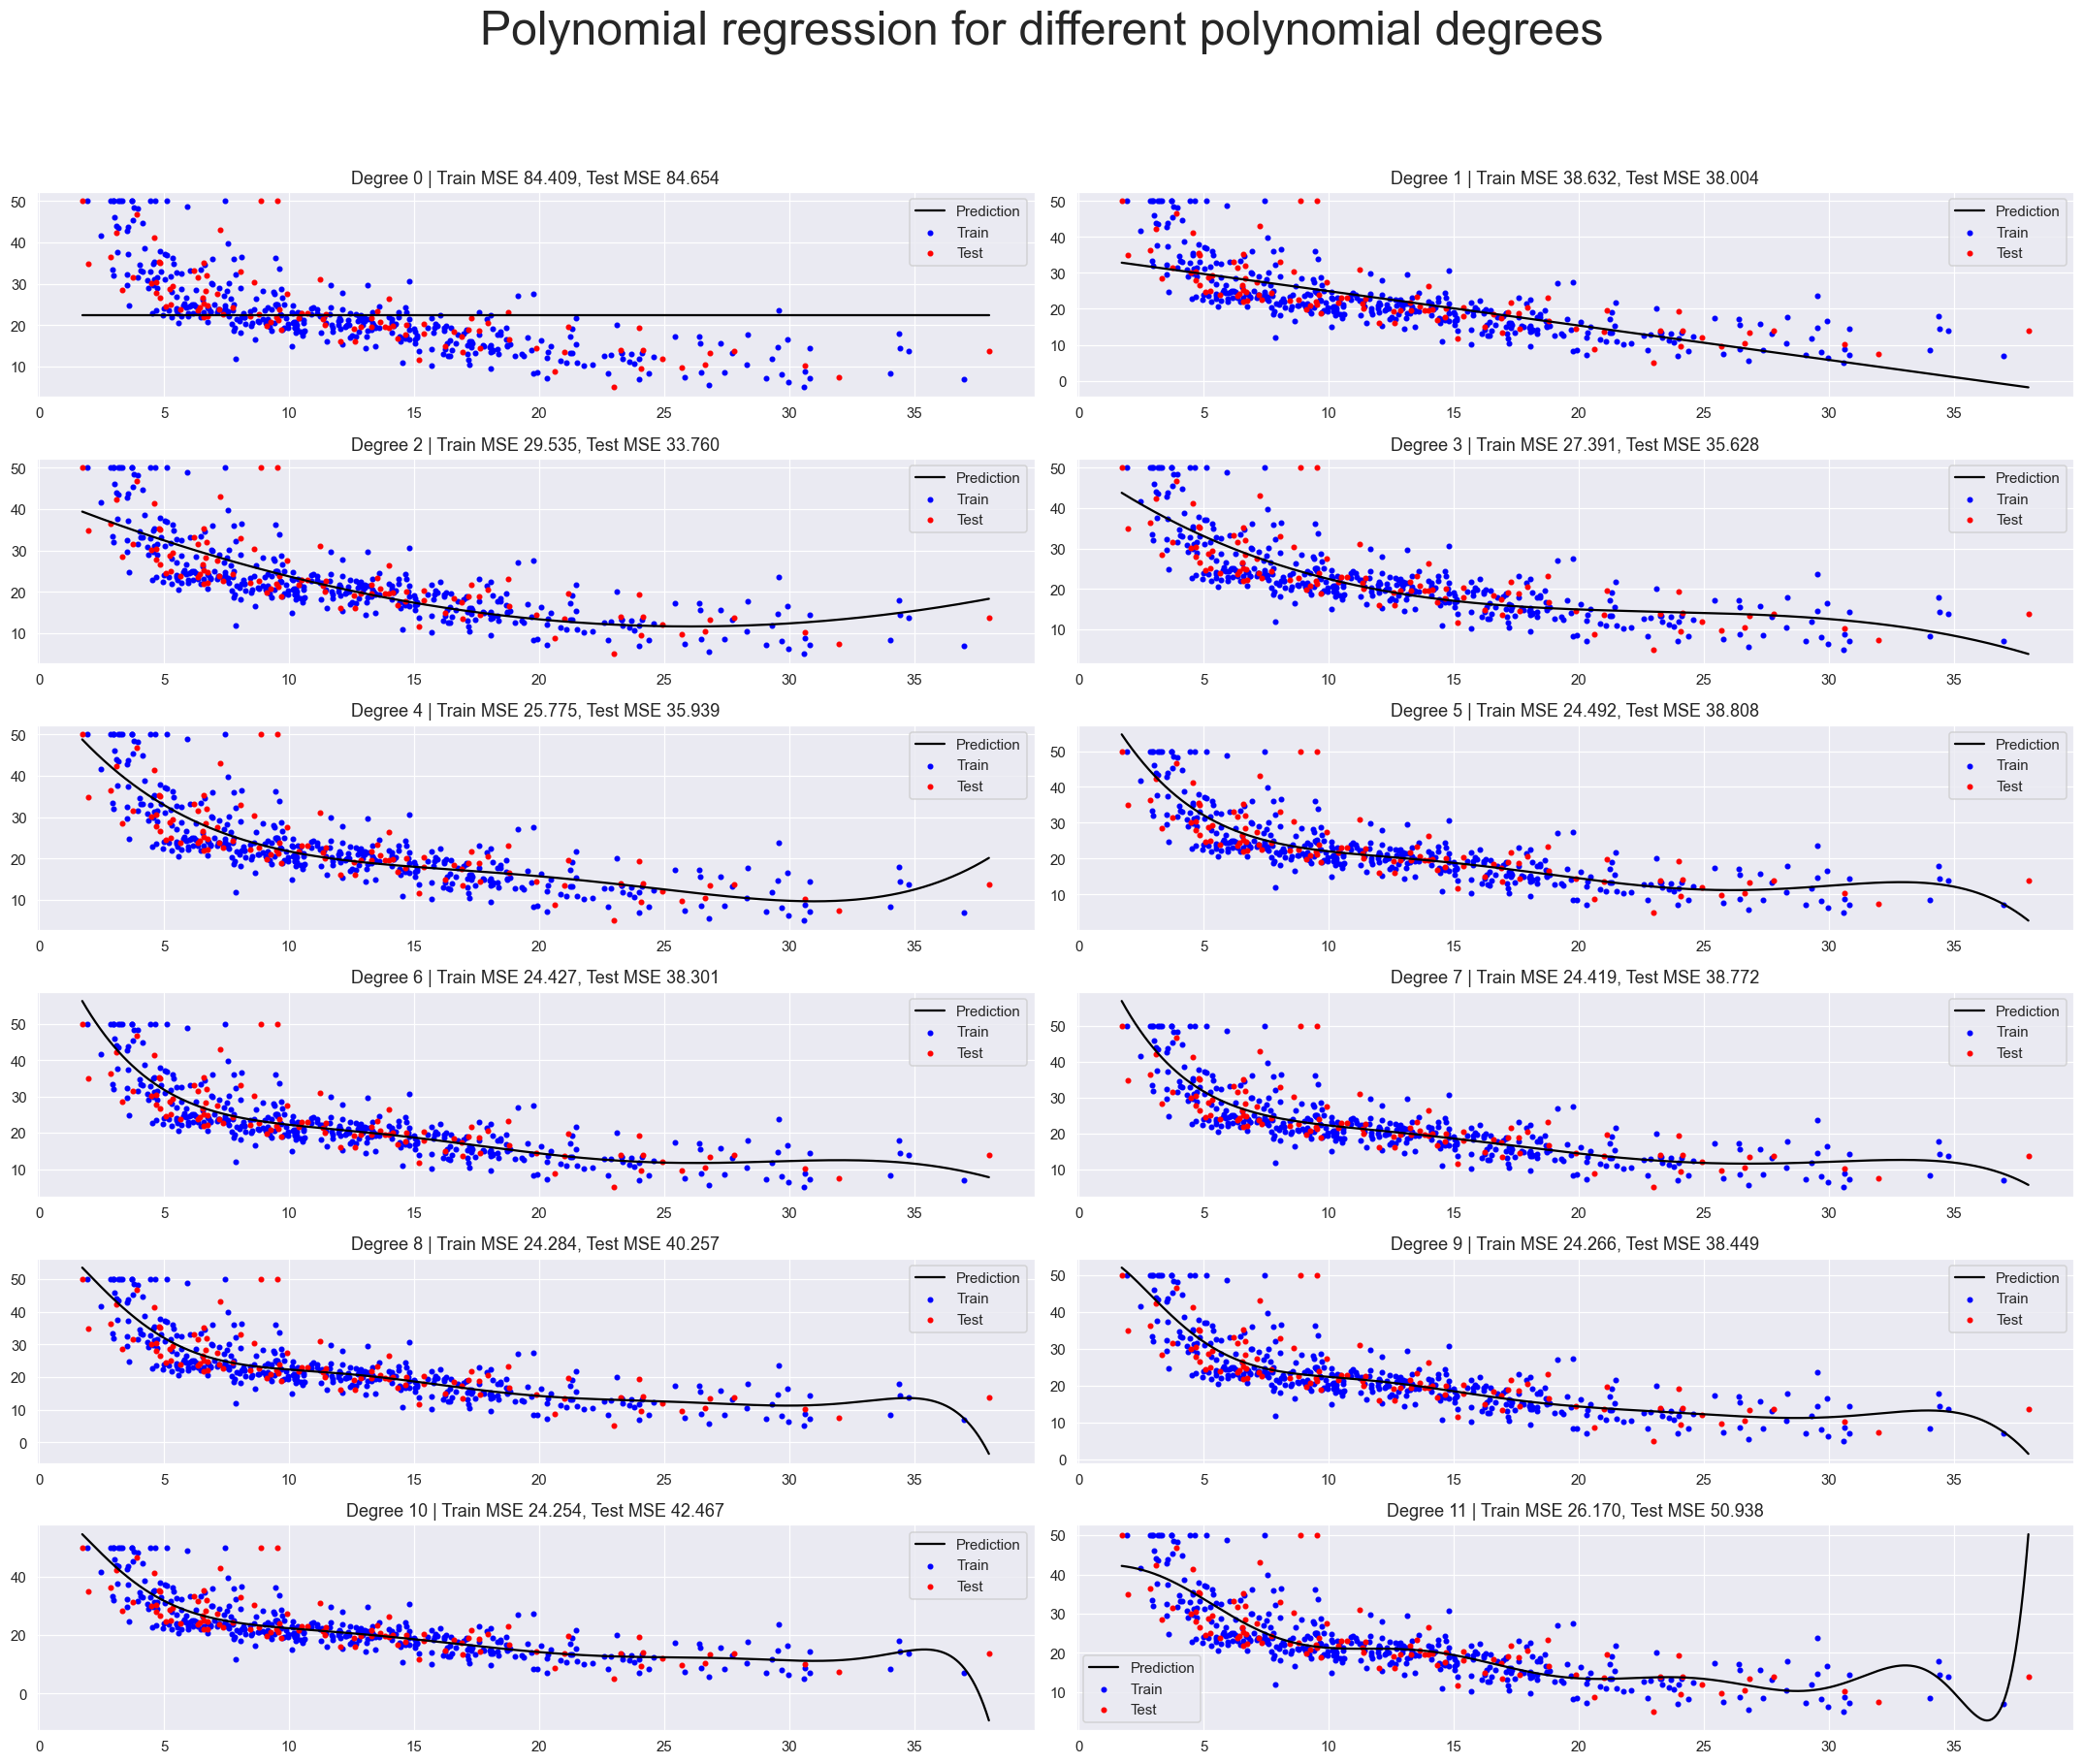

In [12]:
degrees = list(range(12))
models = list()
train_mses = list()
test_mses = list()

X_grid = np.linspace(min(X_train_s.min(), X_test_s.min()), 
                     max(X_train_s.max(), X_test_s.max()), num=1001)

plt.figure(figsize=(20,16))
for i, degree in enumerate(degrees):
    plt.subplot(len(degrees)//2, 2, i+1) 
    
    # Transform features
    poly = PolynomialFeatures(degree=degree)
    Phi_train, Phi_test = poly.fit_transform(X_train_s), poly.fit_transform(X_test_s)
    Phi_grid = poly.fit_transform(X_grid[:,np.newaxis])
    
    # Fit model
    lr_poly = LinearRegression().fit(Phi_train, y_train)
    models.append(lr_poly)
    
    # Evaluate
    train_mse = mean_squared_error(lr_poly.predict(Phi_train), y_train)
    train_mses.append(train_mse)
    test_mse = mean_squared_error(lr_poly.predict(Phi_test), y_test)
    test_mses.append(test_mse)
    
    plt.plot(X_grid, lr_poly.predict(Phi_grid), 'k', label='Prediction')
    plt.scatter(X_train_s, y_train, color='b', marker='.', label='Train')
    plt.scatter(X_test_s, y_test, color='r', marker='.', label='Test')
    plt.title('Degree {} | Train MSE {:.3f}, Test MSE {:.3f}'.format(degree, train_mse, test_mse))
    plt.legend()
    
plt.suptitle('Polynomial regression for different polynomial degrees', y=1.05, fontsize=32)
plt.tight_layout()

Let's plot mean-squared error vs. polynomial degree for the train and test sets.

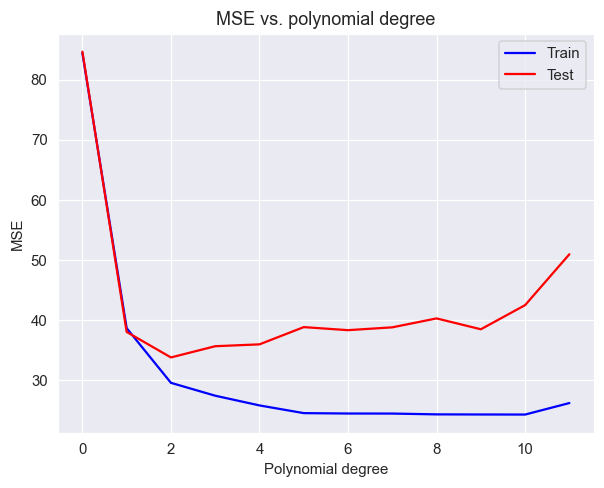

In [13]:
plt.plot(degrees, train_mses, color='b', label='Train')
plt.plot(degrees, test_mses, color='r', label='Test')
plt.title('MSE vs. polynomial degree')
plt.ylabel('MSE')
plt.xlabel('Polynomial degree')
plt.legend()
plt.show()

***
**Question**: 🤨 What's going on here? Does this match your earlier findings, or your intuition about which model was most appropriate? Why isn't test error behaving the same as training error?

_Answer:_ This can be explained by the _bias-variance trade-off_ associated with predictive models. 
An overly simplistic model (e.g. simple linear regression) may suffer from _high bias_ or _underfitting_, while an overly complex model (e.g. high-degree polynomial regression) may suffer from _high variance_ or _overfitting_.
We'll discuss this more in lecture 5, when we cover regularisation as a strategy to avoid overfitting.

***
### 3. Ridge regression

One solution for managing the bias-variance trade-off is regularisation. 
In the context of regression, one can simply add a penalty term to the least-squares cost function in order to encourage weight vectors that are sparse and/or small in magnitude.
In this section, we'll experiment with ridge regression, where a $L_2$ (Tikhonov) penalty term is added to the cost function as follows:

$$
C(\mathbf{w}) = \| \mathbf{y} - \mathbf{X} \mathbf{w} \|_2^2 + \alpha \| \mathbf{w} \|_2^2
$$

***
**Exercise:** In lectures, we derived an analytic expression for the optimal weights $\mathbf{w}^* = \left[\mathbf{X}^\top \mathbf{X} + \alpha \mathbf{I} \right]^{-1} \mathbf{X}^\top \mathbf{y}$. Attempt the derivation yourself using the following matrix calculus identities: 

$$
\begin{gather}
    \nabla_{\mathbf{w}} \mathbf{w}^\top \mathbf{x} = \nabla_{\mathbf{w}} \mathbf{x}^\top \mathbf{w} = \mathbf{x}^\top \\
    \nabla_{\mathbf{w}} \mathbf{A}\mathbf{w} = \mathbf{A} \\
    \nabla_{\mathbf{w}} \mathbf{w}^\top \mathbf{A}\mathbf{w} = \mathbf{w}^\top \left(\mathbf{A}^\top + \mathbf{A}\right)
\end{gather}
$$

where vector $\mathbf{x}$ and matrix $\mathbf{A}$ are constants (independent of $\mathbf{w}$).

hint: $\mathbf{w}^\top \mathbf{w} = \mathbf{w}^\top \mathbf{I}\mathbf{w}$

**Solution:**
Under a decision theoretic framework, the empirical risk can be expressed as 
$$
C(\mathbf{w}) = \|\mathbf{X} \mathbf{w} - \mathbf{y}\|_2^2 + \alpha \| \mathbf{w} \|_2^2 = \mathbf{w}^\top \mathbf{X}^\top \mathbf{X} \mathbf{w} - \mathbf{w}^\top \mathbf{X}^\top \mathbf{y}  - \mathbf{y}^\top \mathbf{X} \mathbf{w} + \mathbf{y}^\top \mathbf{y} + \alpha \mathbf{w}^\top \mathbf{w}
$$

The optimal weight vector is a minimiser of the empirical risk, i.e. $\mathbf{w}^\star \in \arg \min_{\mathbf{w}} C(\mathbf{w})$. 
To get the _normal equations_ we solve for the stationary points of $C(\mathbf{w})$, i.e. $\nabla_{\mathbf{w}} C(\mathbf{w}) = 0$.
We have

$$
\nabla_{\mathbf{w}} C(\mathbf{w}) = \nabla_{\mathbf{w}} (\mathbf{w}^T \mathbf{X}^\top \mathbf{X} \mathbf{w}) - \nabla_{\mathbf{w}} ( \mathbf{w}^\top \mathbf{X}^\top \mathbf{y}) - \nabla_{\mathbf{w}} (\mathbf{y}^\top \mathbf{X} \mathbf{w}) = 2 \mathbf{w}^\top \mathbf{X}^\top \mathbf{X} - 2 \mathbf{y}^\top \mathbf{X} + 2 \alpha \mathbf{w}^\top \mathbf{I} 
$$

which implies $\mathbf{w}^* = \left[\mathbf{X}^\top \mathbf{X} + \alpha \mathbf{I} \right]^{-1} \mathbf{X}^\top \mathbf{y}$
***


We'll start by defining `alpha=0.002` and rescaling `LSTAT`. You'll need to rescale the `LSTAT` feature (e.g. divide by 100) in order to avoid numerical issues.

In [14]:
X_train_s = X_train_s / 100.0
X_test_s = X_test_s / 100.0

X_train_b = np.column_stack((np.ones_like(X_train_s), X_train_s))
X_test_b = np.column_stack((np.ones_like(X_test_s), X_test_s))

***
Exercise: Implement ridge regression using the analytic expression for the optimal weights in the cell below.
***

In [15]:
A = np.identity(X_train_s.shape[1])
w = np.linalg.solve((X_train_b.T @ X_train_b + 0.002 * A), (X_train_b.T @ y_train)) # fill in
print('Weights:', w)

Weights: [ 34.50885782 -95.74871371]


Or you could use the `Ridge` class from scikit-learn to do the same thing.

In [16]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=0.002).fit(X_train_s, y_train)
print('Weights:', ridge.coef_)
print('Intercept:', ridge.intercept_)

Weights: [-95.70677598]
Intercept: 34.50322272934912


We then copy code from the previous section, making the replacement `LinearRegression()` -> `Ridge(alpha = 0.002)`.

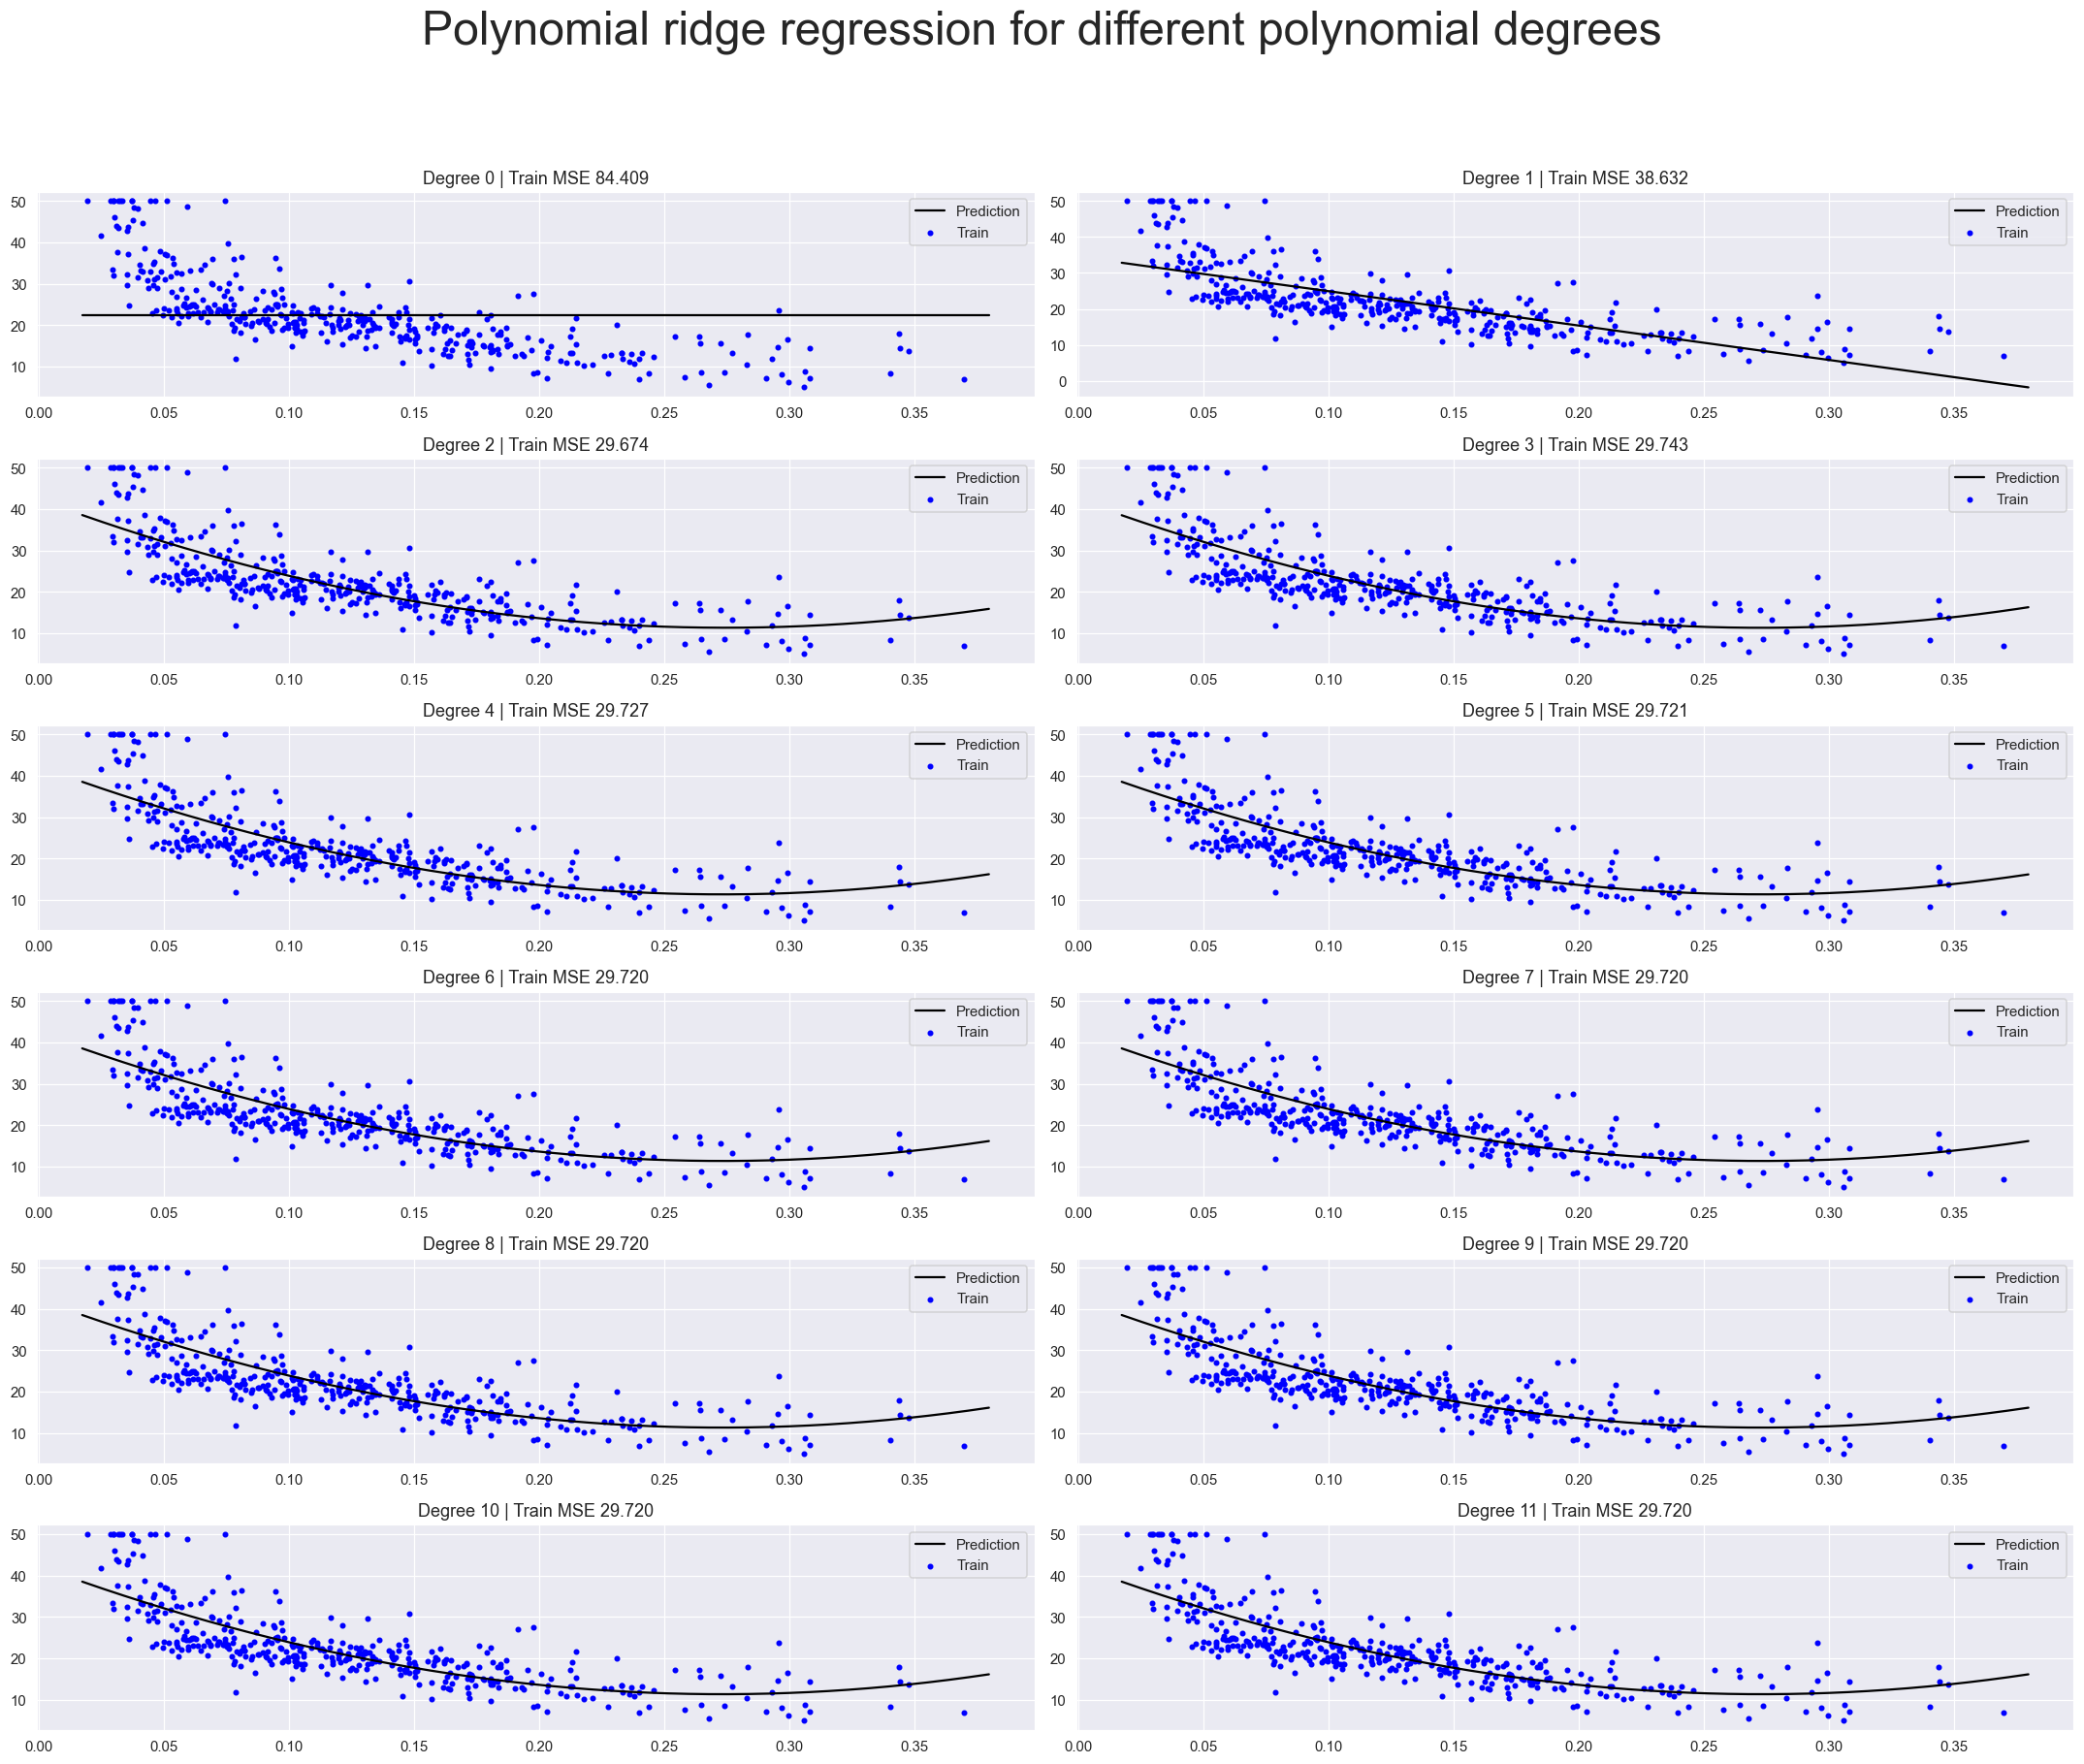

In [17]:
degrees = list(range(12))
models = list()
train_mses = list()
test_mses = list()

X_grid = np.linspace(min(X_train_s.min(), X_test_s.min()), 
                     max(X_train_s.max(), X_test_s.max()), num=1001)

plt.figure(figsize=(20,16))
for i, degree in enumerate(degrees):
    plt.subplot(len(degrees)//2, 2, i+1) 
    
    # Transform features
    poly = PolynomialFeatures(degree=degree)
    Phi_train, Phi_test = poly.fit_transform(X_train_s), poly.fit_transform(X_test_s)
    Phi_grid = poly.fit_transform(X_grid[:,np.newaxis])
    
    # Fit model
    lr_poly = Ridge(alpha = 0.002).fit(Phi_train, y_train)
    models.append(lr_poly)
    
    # Evaluate
    train_mse = mean_squared_error(lr_poly.predict(Phi_train), y_train)
    train_mses.append(train_mse)
    test_mse = mean_squared_error(lr_poly.predict(Phi_test), y_test)
    test_mses.append(test_mse)
    
    plt.plot(X_grid, lr_poly.predict(Phi_grid), 'k', label='Prediction')
    plt.scatter(X_train_s, y_train, color='b', marker='.', label='Train')
    #plt.scatter(X_test_s, y_test, color='r', marker='.', label='Test')
    plt.title('Degree {} | Train MSE {:.3f}'.format(degree, train_mse))
    plt.legend()
    
plt.suptitle('Polynomial ridge regression for different polynomial degrees', y=1.05, fontsize=32)
plt.tight_layout()

Notice that the model is no longer overfitting for larger polynomial degrees.
We can confirm this by plotting the mean-squared error vs. the degree.

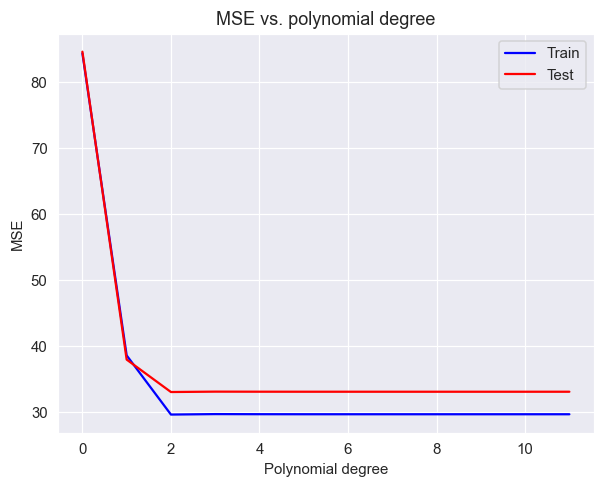

In [18]:
plt.plot(degrees, train_mses, color='b', label='Train')
plt.plot(degrees, test_mses, color='r', label='Test')
plt.title('MSE vs. polynomial degree')
plt.ylabel('MSE')
plt.xlabel('Polynomial degree')
plt.legend()
plt.show()

Finally, we'll plot the L2 norm of the weights versus the polynomial degree. You should compare this with the non-regularized values!

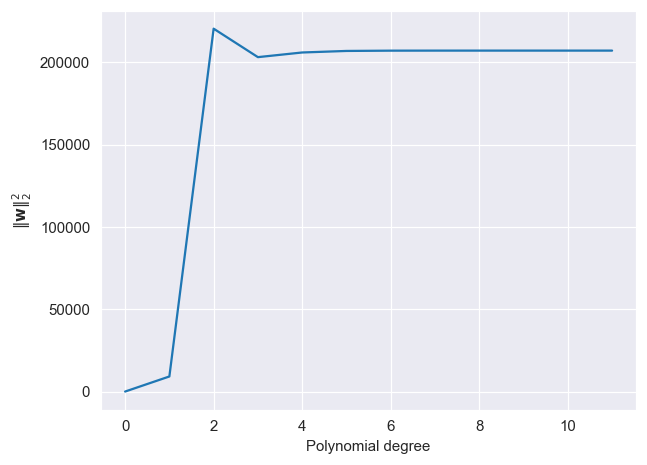

In [19]:
w_L2 = [np.sum(m.coef_**2) for m in models]
plt.plot(degrees, w_L2)
plt.xlabel('Polynomial degree')
plt.ylabel(r'$\| \mathbf{w} \|_2^2$')
plt.show()

### 4. LASSO regression

Similar to ridge regression, LASSO regression adds a penalty term to the least-squares cost function. However, LASSO uses a $L_1$ penalty term instead of a $L_2$ penalty term:

$$
C(\mathbf{w}) = \| \mathbf{y} - \mathbf{X} \mathbf{w} \|_2^2 + \alpha \| \mathbf{w} \|_1
$$

The LASSO penalty term encourages sparsity in the weight vector, which can be useful for feature selection. Lasso encourages solutions to sit on the axes, therefore some of the weights are set to zero.

However, unfortunately, there is no closed-form solution for the optimal weights in the LASSO case. We have to use numerical optimisation methods to solve the problem but solutions are sparse and can be found efficiently.

In [20]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.002).fit(X_train_s, y_train)
print('Weights:', lasso.coef_)
print('Intercept:', lasso.intercept_)

Weights: [-95.40078234]
Intercept: 34.46431897079611


We then copy code from the previous section, making the replacement `Ridge(alpha = 0.002)` -> `Lasso(alpha = 0.002)`.

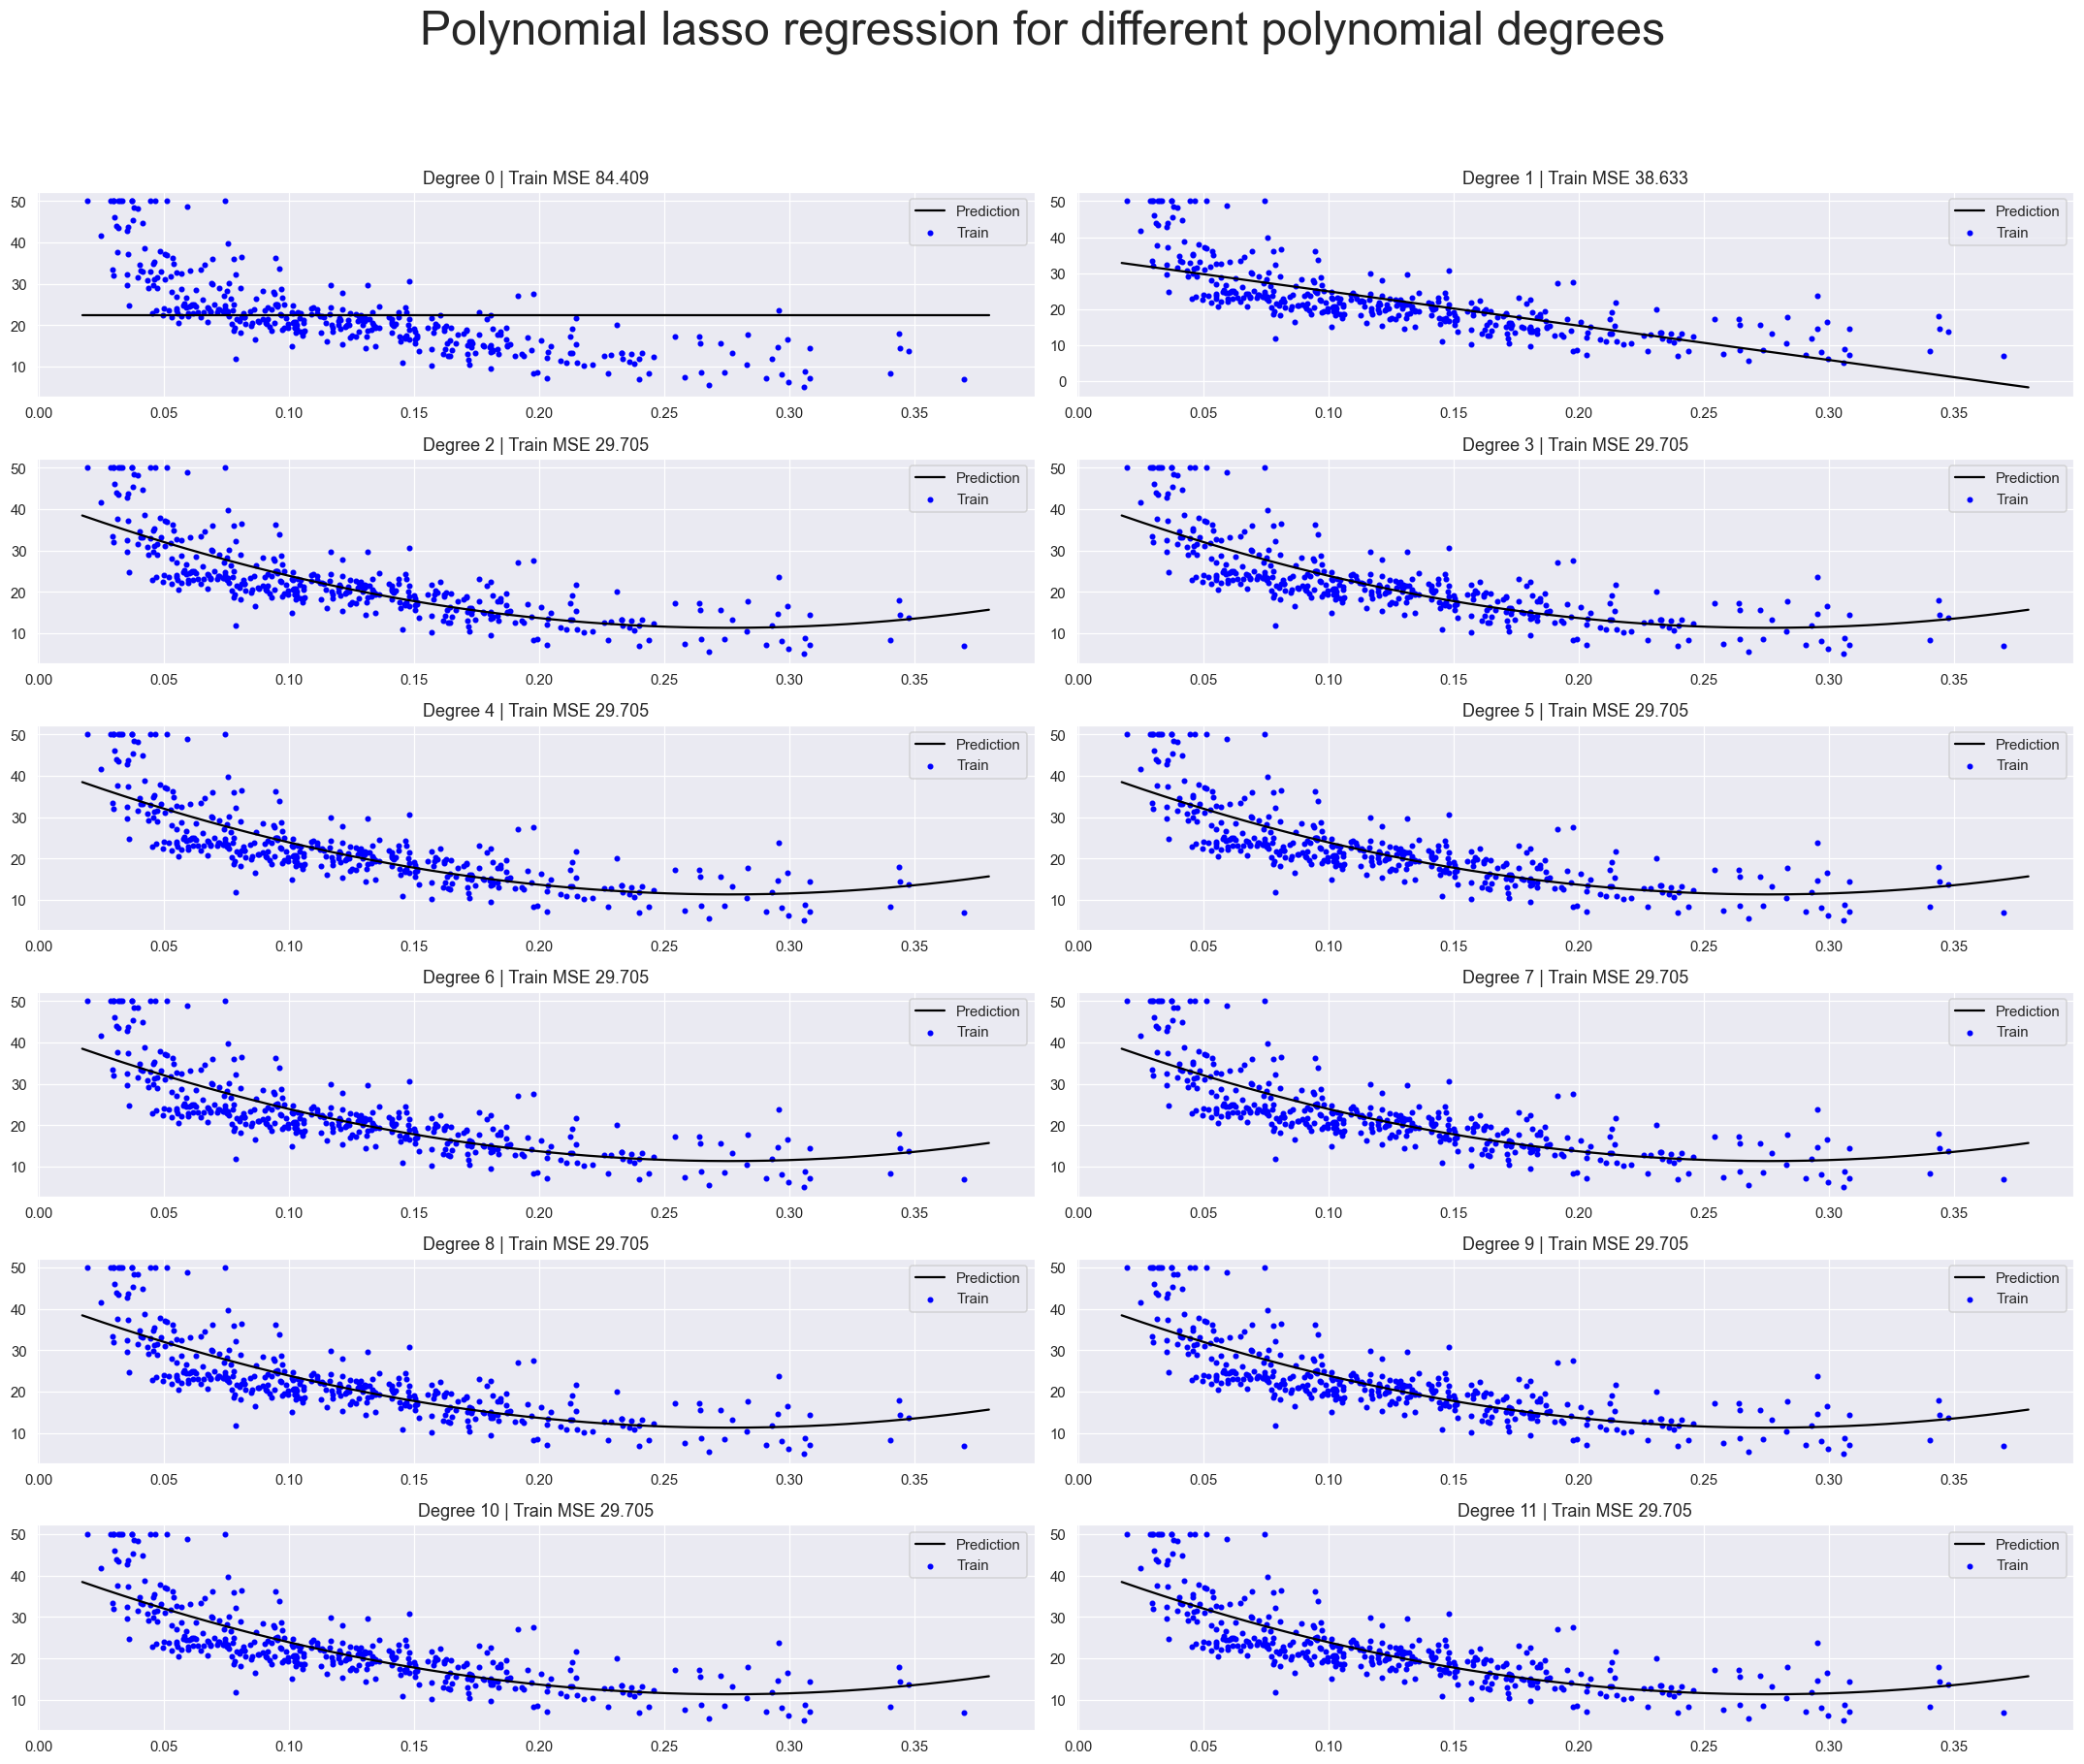

In [21]:
degrees = list(range(12))
models = list()
train_mses = list()
test_mses = list()

X_grid = np.linspace(min(X_train_s.min(), X_test_s.min()), 
                     max(X_train_s.max(), X_test_s.max()), num=1001)

plt.figure(figsize=(20,16))
for i, degree in enumerate(degrees):
    plt.subplot(len(degrees)//2, 2, i+1) 
    
    # Transform features
    poly = PolynomialFeatures(degree=degree)
    Phi_train, Phi_test = poly.fit_transform(X_train_s), poly.fit_transform(X_test_s)
    Phi_grid = poly.fit_transform(X_grid[:,np.newaxis])
    
    # Fit model
    lr_poly = Lasso(alpha = 0.002).fit(Phi_train, y_train)
    models.append(lr_poly)
    
    # Evaluate
    train_mse = mean_squared_error(lr_poly.predict(Phi_train), y_train)
    train_mses.append(train_mse)
    test_mse = mean_squared_error(lr_poly.predict(Phi_test), y_test)
    test_mses.append(test_mse)
    
    plt.plot(X_grid, lr_poly.predict(Phi_grid), 'k', label='Prediction')
    plt.scatter(X_train_s, y_train, color='b', marker='.', label='Train')
    #plt.scatter(X_test_s, y_test, color='r', marker='.', label='Test')
    plt.title('Degree {} | Train MSE {:.3f}'.format(degree, train_mse))
    plt.legend()
    
plt.suptitle('Polynomial lasso regression for different polynomial degrees', y=1.05, fontsize=32)
plt.tight_layout()

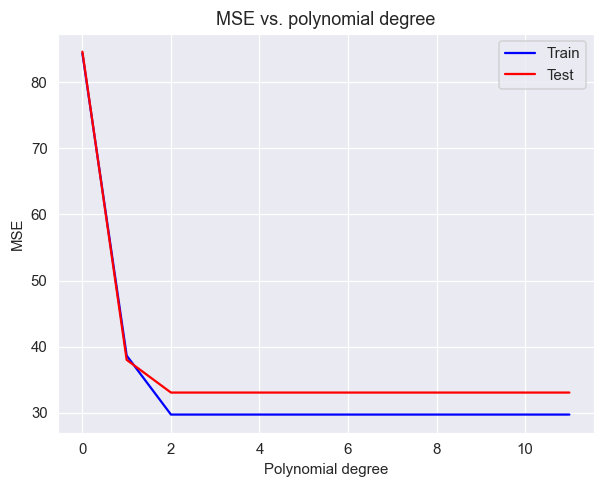

In [22]:
plt.plot(degrees, train_mses, color='b', label='Train')
plt.plot(degrees, test_mses, color='r', label='Test')
plt.title('MSE vs. polynomial degree')
plt.ylabel('MSE')
plt.xlabel('Polynomial degree')
plt.legend()
plt.show()

Finally, we'll plot the L1 norm of the weights versus the polynomial degree.

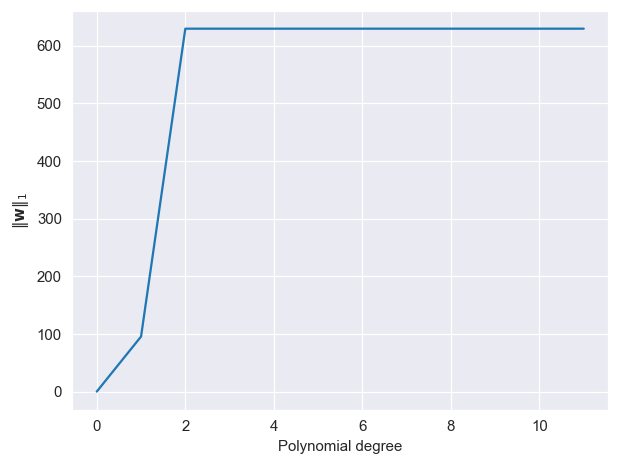

In [23]:
w_L1 = [np.sum(abs(m.coef_)) for m in models]
plt.plot(degrees, w_L1)
plt.xlabel('Polynomial degree')
plt.ylabel(r'$\| \mathbf{w} \|_1$')
plt.show()

## Bonus: Ridge regression (this section is optional)

You may want to experiment with different settings for the regularisation parameter $\alpha$. 
How could you select the 'best' value of $\alpha$ to achieve a good balance between training error and generalisation error?